Predicting PRIDICT model...
Using device: cuda
Predicting fold 1...
Fold 1 RMSE: 2.693498054813001
Fold 1 Pearson: 0.7476880908056378, Spearman: 0.7485515133191052
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Predicting fold 2...
Fold 2 RMSE: 2.73854269983683
Fold 2 Pearson: 0.749779560635061, Spearman: 0.7472228020127922
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Predicting fold 3...
Fold 3 RMSE: 2.7014704430558174
Fold 3 Pearson: 0.7414460397057919, Spearman: 0.7394926549222143
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Predicting fold 4...
Fold 4 RMSE: 2.814291799284201
Fold 4 Pearson: 0.7280360917817752, Spearman: 0.7372763141350233
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Predicting fold 5...
Fold 5 RMSE: 2.775719772349647
Fold 5 Pearson: 0.7312983240198889, Spearman: 0.7392113088090647
Fold 1 Pearson: 0.7314597876614986, Spearman: 0.732082128

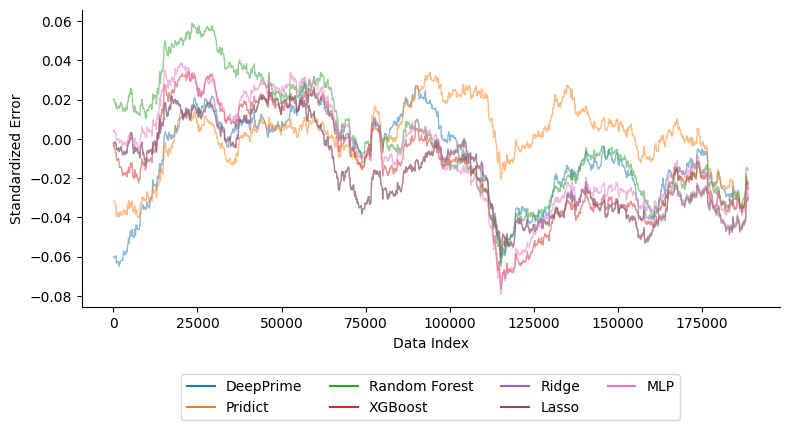

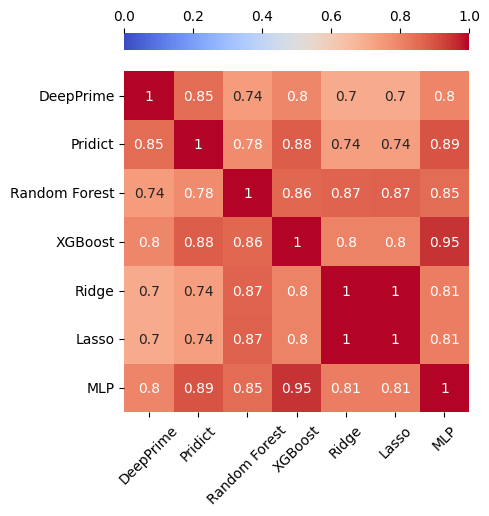

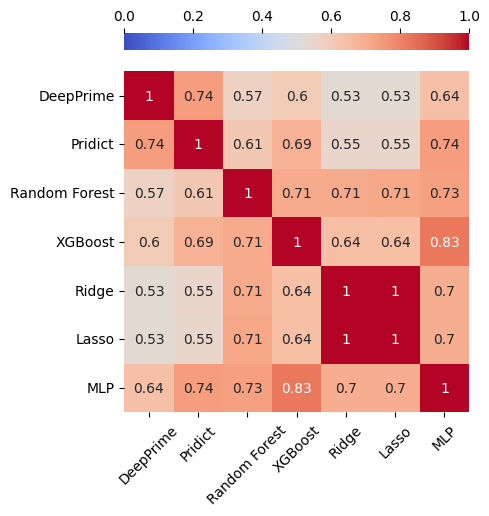

In [3]:
# load the pridict, deepprime and conventional ML models
import os
import sys
import numpy as np
import pandas as pd
import pickle
import torch
import skorch

from models.deepprime import predict as predict_deep_prime
from models.pridict import predict as predict_pridict
from models.conventional_ml_models import MLP
from collections import defaultdict

# suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

for dataf in ['dp-hek293t-pe2']:
    data_dp = f'dp-{dataf}.csv'
    data_pd = f'pd-{dataf}.csv'

    prediction_pd = predict_pridict(data_pd, num_features=24, device='cuda' if torch.cuda.is_available() else 'cpu', dropout=0)
    prediction_dp = predict_deep_prime(data_dp, num_features=24, dropout=0)

    prediction_mlp = defaultdict(list)
    prediction_rf = defaultdict(list)
    prediction_xgb = defaultdict(list)
    prediction_ridge = defaultdict(list)
    prediction_lasso = defaultdict(list)

    data = pd.read_csv(f'models/data/conventional-ml/ml-{dataf}.csv')
    for i in range(5):
        fold = i + 1
        # load the test data
        X_test = data[data['fold'] == i].iloc[:, :24].values
        y_test = data[data['fold'] == i].iloc[:, -2].values
        # load the models
        with open(f'models/trained-models/conventional-ml/random_forest-{dataf}-fold-{fold}.pkl', 'rb') as f:
            rf = pickle.load(f)
        with open(f'models/trained-models/conventional-ml/xgboost-{dataf}-fold-{fold}.pkl', 'rb') as f:
            xgb = pickle.load(f)
        with open(f'models/trained-models/conventional-ml/ridge-{dataf}-fold-{fold}.pkl', 'rb') as f:
            ridge = pickle.load(f)
        with open(f'models/trained-models/conventional-ml/lasso-{dataf}-fold-{fold}.pkl', 'rb') as f:
            lasso = pickle.load(f)
        mlp_model = skorch.NeuralNetRegressor(
                module=MLP,
                device='cuda',
                module__hidden_layer_sizes = (64, 64,),
            )
        mlp_model.initialize()
        mlp_model.load_params(f_params=f'models/trained-models/conventional-ml/mlp-{dataf}-fold-{fold}.pt')

        prediction_rf[i] = rf.predict(X_test)
        prediction_xgb[i] = xgb.predict(X_test)
        prediction_ridge[i] = ridge.predict(X_test)
        prediction_lasso[i] = lasso.predict(X_test)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        prediction_mlp[i] = mlp_model.predict(X_test)


    # concatenate the predictions for each fold into a single array
    prediction_pd_list = np.concatenate([prediction_pd[fold].flatten() for fold in range(5)])
    prediction_dp_list = np.concatenate([prediction_dp[fold].flatten() for fold in range(5)])
    prediction_rf_list = np.concatenate([prediction_rf[fold] for fold in range(5)])
    prediction_xgb_list = np.concatenate([prediction_xgb[fold] for fold in range(5)])
    prediction_ridge_list = np.concatenate([prediction_ridge[fold] for fold in range(5)])
    prediction_lasso_list = np.concatenate([prediction_lasso[fold] for fold in range(5)])
    prediction_mlp_list = np.concatenate([prediction_mlp[fold].flatten() for fold in range(5)])

    print('Concatenated')

    # calculate the squared error from the predictions
    y_test = np.concatenate([data[data['fold'] == i].iloc[:, -2].values for i in range(5)])
    mse_dp = (y_test - prediction_dp_list)
    mse_pd = (y_test - prediction_pd_list)
    mse_rf = (y_test - prediction_rf_list)
    mse_xgb = (y_test - prediction_xgb_list)
    mse_ridge = (y_test - prediction_ridge_list)
    mse_lasso = (y_test - prediction_lasso_list)
    mse_mlp = (y_test - prediction_mlp_list)

    # print the pearson correlation coefficient between model predictions and true values
    from scipy.stats import pearsonr
    print('DeepPrime:', pearsonr(y_test, prediction_dp_list)[0])
    print('Pridict:', pearsonr(y_test, prediction_pd_list)[0])
    print('Random Forest:', pearsonr(y_test, prediction_rf_list)[0])
    print('XGBoost:', pearsonr(y_test, prediction_xgb_list)[0])
    print('Ridge:', pearsonr(y_test, prediction_ridge_list)[0])
    print('Lasso:', pearsonr(y_test, prediction_lasso_list)[0])
    print('MLP:', pearsonr(y_test, prediction_mlp_list)[0])

    # standardize the error
    mse_dp = (mse_dp - np.mean(mse_dp)) / np.std(mse_dp)
    mse_pd = (mse_pd - np.mean(mse_pd)) / np.std(mse_pd)
    mse_rf = (mse_rf - np.mean(mse_rf)) / np.std(mse_rf)
    mse_xgb = (mse_xgb - np.mean(mse_xgb)) / np.std(mse_xgb)
    mse_ridge = (mse_ridge - np.mean(mse_ridge)) / np.std(mse_ridge)
    mse_lasso = (mse_lasso - np.mean(mse_lasso)) / np.std(mse_lasso)
    mse_mlp = (mse_mlp - np.mean(mse_mlp)) / np.std(mse_mlp)


    # plot the smoothened error using a moving average
    import matplotlib.pyplot as plt
    import seaborn as sns

    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    # downsample the data to improve visualization
    x = np.arange(len(mse_dp))
    downsample = 100
    x = x[::downsample]
    mse_dp = mse_dp[::downsample]
    mse_pd = mse_pd[::downsample]
    mse_rf = mse_rf[::downsample]
    mse_xgb = mse_xgb[::downsample]
    mse_ridge = mse_ridge[::downsample]
    mse_lasso = mse_lasso[::downsample]
    mse_mlp = mse_mlp[::downsample]

    fig, axes = plt.subplots(1, 1, figsize=(8, 4.5))
    window = 1000
    # update x to match the length of the moving average
    x = x[:-(window - 1)]
    axes.plot(x, moving_average(mse_dp, window), label='DeepPrime')
    axes.plot(x, moving_average(mse_pd, window), label='Pridict')
    axes.plot(x, moving_average(mse_rf, window), label='Random Forest')
    axes.plot(x, moving_average(mse_xgb, window), label='XGBoost')
    axes.plot(x, moving_average(mse_ridge, window), label='Ridge')
    axes.plot(x, moving_average(mse_lasso, window), label='Lasso')
    axes.plot(x, moving_average(mse_mlp, window), label='MLP')
    # legend of two rows
    axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)

    # set x and y labels
    axes.set_xlabel('Data Index')
    axes.set_ylabel('Standardized Error')


    # reduce thickness and alpha of the lines
    for line in plt.gca().lines:
        line.set_linewidth(1)
        line.set_alpha(0.5)

    # remove the top and right spines
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(os.path.join('dissertation', 'figures', f'error_comparison_{dataf}.png'), dpi=300)

    # calculate the pearson correlation coefficient between each error and plot in heatmap
    from scipy.stats import pearsonr, spearmanr

    mse_dict = {
        'DeepPrime': mse_dp,
        'Pridict': mse_pd,
        'Random Forest': mse_rf,
        'XGBoost': mse_xgb,
        'Ridge': mse_ridge,
        'Lasso': mse_lasso,
        'MLP': mse_mlp,
    }

    fig, axes = plt.subplots(1, 1, figsize=(5, 5.5))

    correlation_matrix = np.zeros((len(mse_dict), len(mse_dict)))
    for i, mse in enumerate(mse_dict.values()):
        for j, mse2 in enumerate(mse_dict.values()):
            correlation_matrix[i, j] = pearsonr(mse, mse2)[0]

    # heat map with cbar in range 0 to 1, horizontal and on top of the plot
    sns.heatmap(correlation_matrix, ax=axes, cbar_kws={'location': 'top', 'pad': 0.05}, vmin=0, vmax=1, cmap='coolwarm', annot=True)

    # set cbar limit
    # cbar = axes.collections[0].colorbar
    # cbar.set_ticks([0, 0.5, 1])
    plt.xticks(np.arange(len(mse_dict)) + 0.5, mse_dict.keys(), rotation=45)
    plt.yticks(np.arange(len(mse_dict)) + 0.5, mse_dict.keys(), rotation=0)

    plt.tight_layout()
    plt.savefig(os.path.join('dissertation', 'figures', f'error_correlation_{dataf}_pearson.png'), dpi=300)

    fig, axes = plt.subplots(1, 1, figsize=(5, 5.5))

    correlation_matrix = np.zeros((len(mse_dict), len(mse_dict)))
    for i, mse in enumerate(mse_dict.values()):
        for j, mse2 in enumerate(mse_dict.values()):
            # spearman correlation
            correlation_matrix[i, j] = spearmanr(mse, mse2)[0]

    # heat map with cbar in range 0 to 1, horizontal and on top of the plot
    sns.heatmap(correlation_matrix, ax=axes, cbar_kws={'location': 'top', 'pad': 0.05}, vmin=0, vmax=1, cmap='coolwarm', annot=True)

    plt.xticks(np.arange(len(mse_dict)) + 0.5, mse_dict.keys(), rotation=45)
    plt.yticks(np.arange(len(mse_dict)) + 0.5, mse_dict.keys(), rotation=0)

    # save the plots
    plt.tight_layout()
    plt.savefig(os.path.join('dissertation', 'figures', f'error_correlation_{dataf}_spearman.png'), dpi=300)

Predicting PRIDICT model...
Using device: cuda
Predicting fold 1...
Fold 1 RMSE: 18.983238850366327
Fold 1 Pearson: 0.8059717777848316, Spearman: 0.7906951115420144
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Predicting fold 2...
Fold 2 RMSE: 18.95360492773973
Fold 2 Pearson: 0.8104036001131493, Spearman: 0.8034605578659045
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Predicting fold 3...
Fold 3 RMSE: 18.892024026918353
Fold 3 Pearson: 0.8127508784402901, Spearman: 0.8058904616698042
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Predicting fold 4...
Fold 4 RMSE: 18.628796886407887
Fold 4 Pearson: 0.8018957982262612, Spearman: 0.7892999257028551
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Predicting fold 5...
Fold 5 RMSE: 18.334942914167218
Fold 5 Pearson: 0.8191543419571745, Spearman: 0.8228603499995742
Fold 1 Pearson: 0.7892933160401239, Spearman: 0.7959

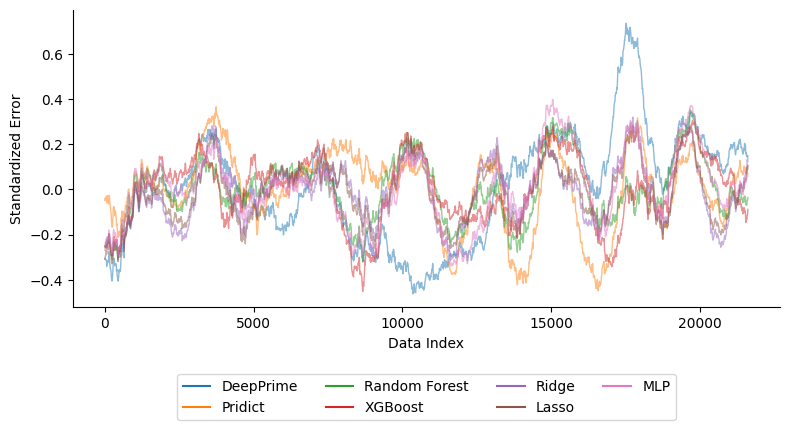

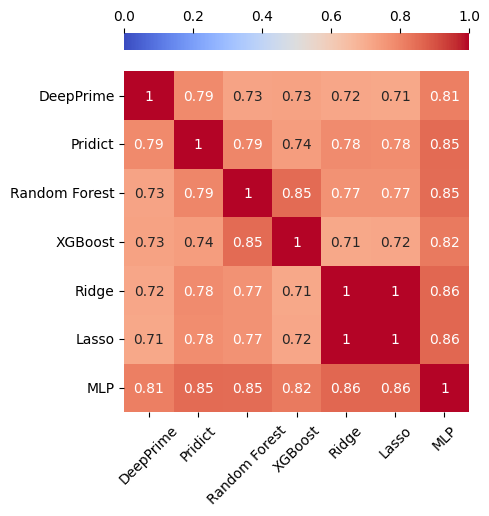

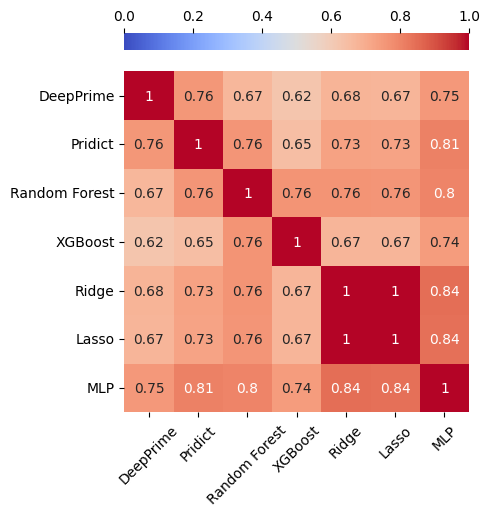

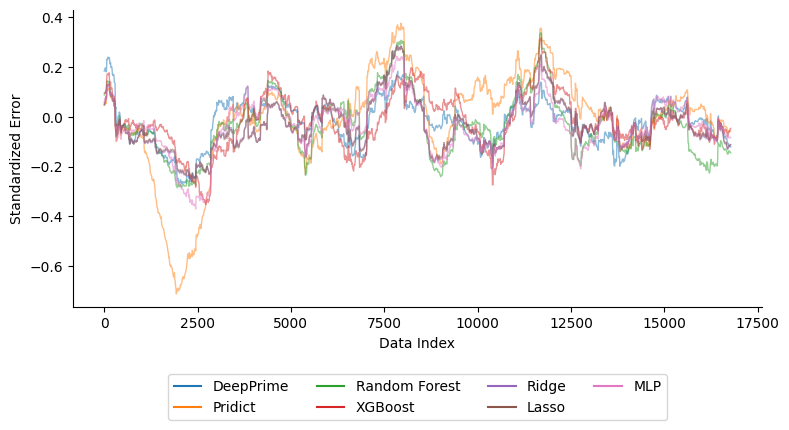

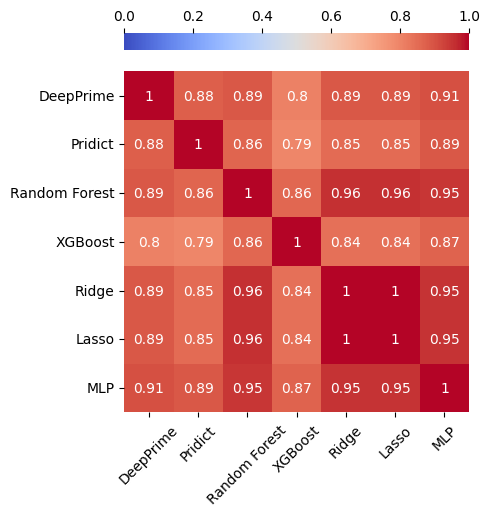

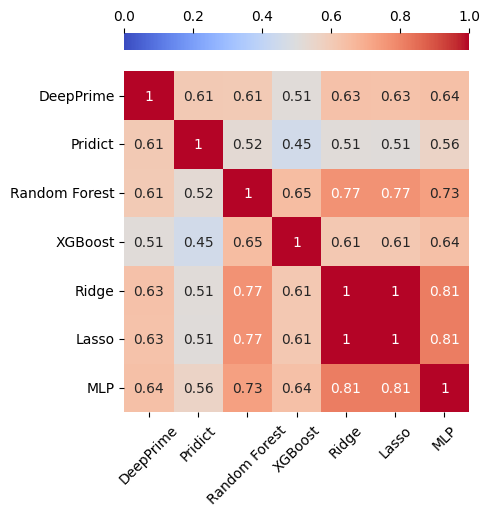

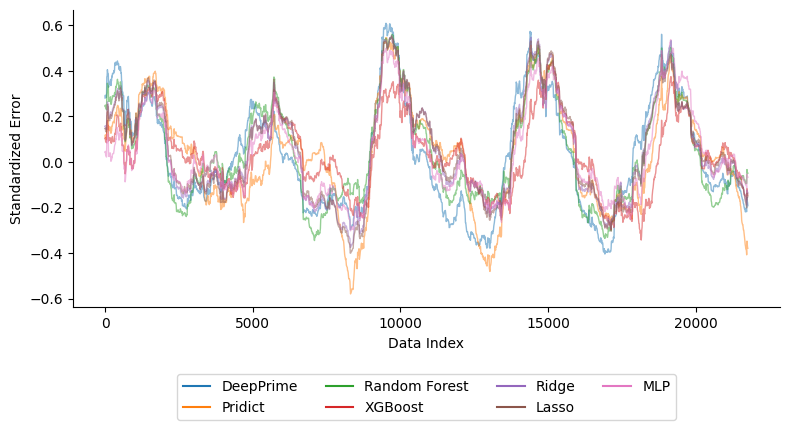

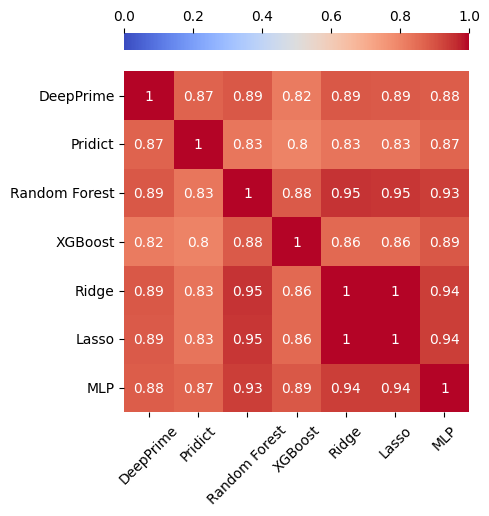

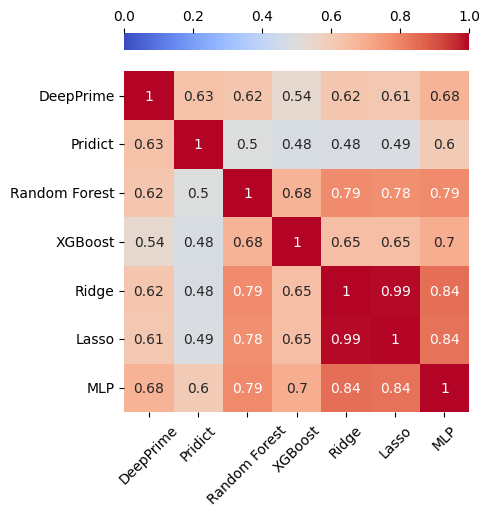

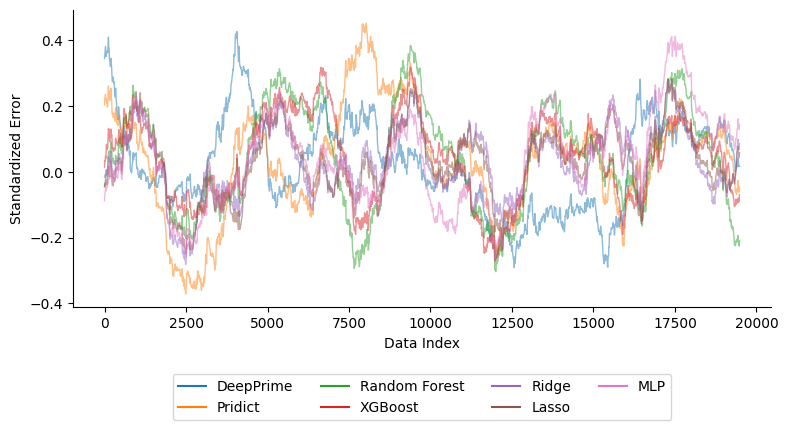

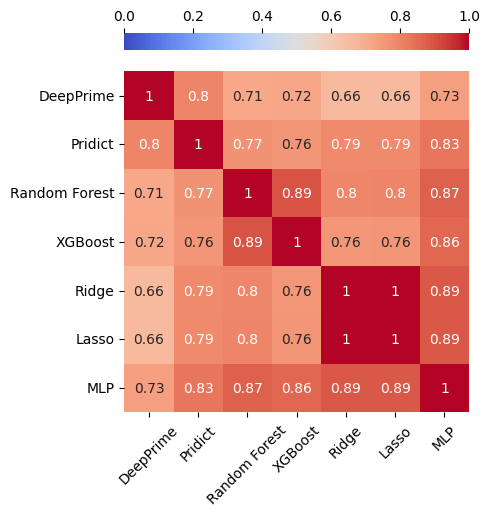

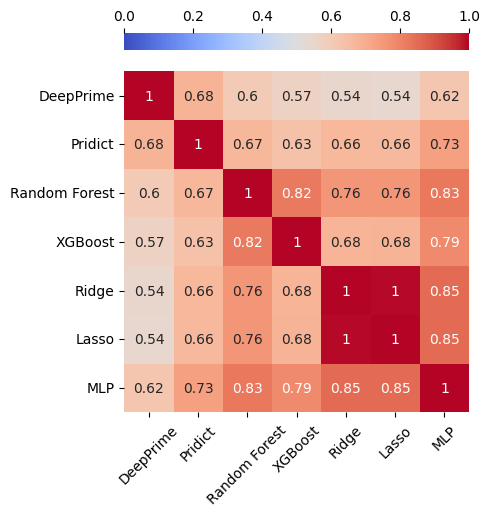

In [4]:
# load the pridict, deepprime and conventional ML models
import os
import sys
import numpy as np
import pandas as pd
import pickle
import torch
import skorch

from models.deepprime import predict as predict_deep_prime
from models.pridict import predict as predict_pridict
from models.conventional_ml_models import MLP
from collections import defaultdict

# suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

for dataf in ['pd-hek293t-pe2', 'pd-adv-pe2', 'pd-k562-pe2', 'pd-k562mlh1dn-pe2']:
    data_dp = f'dp-{dataf}.csv'
    data_pd = f'pd-{dataf}.csv'

    prediction_pd = predict_pridict(data_pd, num_features=24, device='cuda' if torch.cuda.is_available() else 'cpu', dropout=0)
    prediction_dp = predict_deep_prime(data_dp, num_features=24, dropout=0)

    prediction_mlp = defaultdict(list)
    prediction_rf = defaultdict(list)
    prediction_xgb = defaultdict(list)
    prediction_ridge = defaultdict(list)
    prediction_lasso = defaultdict(list)

    data = pd.read_csv(f'models/data/conventional-ml/ml-{dataf}.csv')
    for i in range(5):
        fold = i + 1
        # load the test data
        X_test = data[data['fold'] == i].iloc[:, :24].values
        y_test = data[data['fold'] == i].iloc[:, -2].values
        # load the models
        with open(f'models/trained-models/conventional-ml/random_forest-{dataf}-fold-{fold}.pkl', 'rb') as f:
            rf = pickle.load(f)
        with open(f'models/trained-models/conventional-ml/xgboost-{dataf}-fold-{fold}.pkl', 'rb') as f:
            xgb = pickle.load(f)
        with open(f'models/trained-models/conventional-ml/ridge-{dataf}-fold-{fold}.pkl', 'rb') as f:
            ridge = pickle.load(f)
        with open(f'models/trained-models/conventional-ml/lasso-{dataf}-fold-{fold}.pkl', 'rb') as f:
            lasso = pickle.load(f)
        mlp_model = skorch.NeuralNetRegressor(
                module=MLP,
                device='cuda',
                module__hidden_layer_sizes = (64, 64,),
            )
        mlp_model.initialize()
        mlp_model.load_params(f_params=f'models/trained-models/conventional-ml/mlp-{dataf}-fold-{fold}.pt')

        prediction_rf[i] = rf.predict(X_test)
        prediction_xgb[i] = xgb.predict(X_test)
        prediction_ridge[i] = ridge.predict(X_test)
        prediction_lasso[i] = lasso.predict(X_test)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        prediction_mlp[i] = mlp_model.predict(X_test)


    # concatenate the predictions for each fold into a single array
    prediction_pd_list = np.concatenate([prediction_pd[fold].flatten() for fold in range(5)])
    prediction_dp_list = np.concatenate([prediction_dp[fold].flatten() for fold in range(5)])
    prediction_rf_list = np.concatenate([prediction_rf[fold] for fold in range(5)])
    prediction_xgb_list = np.concatenate([prediction_xgb[fold] for fold in range(5)])
    prediction_ridge_list = np.concatenate([prediction_ridge[fold] for fold in range(5)])
    prediction_lasso_list = np.concatenate([prediction_lasso[fold] for fold in range(5)])
    prediction_mlp_list = np.concatenate([prediction_mlp[fold].flatten() for fold in range(5)])

    print('Concatenated')

    # calculate the squared error from the predictions
    y_test = np.concatenate([data[data['fold'] == i].iloc[:, -2].values for i in range(5)])
    mse_dp = (y_test - prediction_dp_list)
    mse_pd = (y_test - prediction_pd_list)
    mse_rf = (y_test - prediction_rf_list)
    mse_xgb = (y_test - prediction_xgb_list)
    mse_ridge = (y_test - prediction_ridge_list)
    mse_lasso = (y_test - prediction_lasso_list)
    mse_mlp = (y_test - prediction_mlp_list)

    # print the pearson correlation coefficient between model predictions and true values
    from scipy.stats import pearsonr
    print('DeepPrime:', pearsonr(y_test, prediction_dp_list)[0])
    print('Pridict:', pearsonr(y_test, prediction_pd_list)[0])
    print('Random Forest:', pearsonr(y_test, prediction_rf_list)[0])
    print('XGBoost:', pearsonr(y_test, prediction_xgb_list)[0])
    print('Ridge:', pearsonr(y_test, prediction_ridge_list)[0])
    print('Lasso:', pearsonr(y_test, prediction_lasso_list)[0])
    print('MLP:', pearsonr(y_test, prediction_mlp_list)[0])

    # standardize the error
    mse_dp = (mse_dp - np.mean(mse_dp)) / np.std(mse_dp)
    mse_pd = (mse_pd - np.mean(mse_pd)) / np.std(mse_pd)
    mse_rf = (mse_rf - np.mean(mse_rf)) / np.std(mse_rf)
    mse_xgb = (mse_xgb - np.mean(mse_xgb)) / np.std(mse_xgb)
    mse_ridge = (mse_ridge - np.mean(mse_ridge)) / np.std(mse_ridge)
    mse_lasso = (mse_lasso - np.mean(mse_lasso)) / np.std(mse_lasso)
    mse_mlp = (mse_mlp - np.mean(mse_mlp)) / np.std(mse_mlp)


    # plot the smoothened error using a moving average
    import matplotlib.pyplot as plt
    import seaborn as sns

    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    # downsample the data to improve visualization
    x = np.arange(len(mse_dp))
    downsample = 10
    x = x[::downsample]
    mse_dp = mse_dp[::downsample]
    mse_pd = mse_pd[::downsample]
    mse_rf = mse_rf[::downsample]
    mse_xgb = mse_xgb[::downsample]
    mse_ridge = mse_ridge[::downsample]
    mse_lasso = mse_lasso[::downsample]
    mse_mlp = mse_mlp[::downsample]

    fig, axes = plt.subplots(1, 1, figsize=(8, 4.5))
    window = 100
    # update x to match the length of the moving average
    x = x[:-(window - 1)]
    axes.plot(x, moving_average(mse_dp, window), label='DeepPrime')
    axes.plot(x, moving_average(mse_pd, window), label='Pridict')
    axes.plot(x, moving_average(mse_rf, window), label='Random Forest')
    axes.plot(x, moving_average(mse_xgb, window), label='XGBoost')
    axes.plot(x, moving_average(mse_ridge, window), label='Ridge')
    axes.plot(x, moving_average(mse_lasso, window), label='Lasso')
    axes.plot(x, moving_average(mse_mlp, window), label='MLP')
    # legend of two rows
    axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)

    # set x and y labels
    axes.set_xlabel('Data Index')
    axes.set_ylabel('Standardized Error')


    # reduce thickness and alpha of the lines
    for line in plt.gca().lines:
        line.set_linewidth(1)
        line.set_alpha(0.5)

    # remove the top and right spines
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(os.path.join('dissertation', 'figures', f'error_comparison_{dataf}.png'), dpi=300)

    # calculate the pearson correlation coefficient between each error and plot in heatmap
    from scipy.stats import pearsonr, spearmanr

    mse_dict = {
        'DeepPrime': mse_dp,
        'Pridict': mse_pd,
        'Random Forest': mse_rf,
        'XGBoost': mse_xgb,
        'Ridge': mse_ridge,
        'Lasso': mse_lasso,
        'MLP': mse_mlp,
    }

    fig, axes = plt.subplots(1, 1, figsize=(5, 5.5))

    correlation_matrix = np.zeros((len(mse_dict), len(mse_dict)))
    for i, mse in enumerate(mse_dict.values()):
        for j, mse2 in enumerate(mse_dict.values()):
            correlation_matrix[i, j] = pearsonr(mse, mse2)[0]

    # heat map with cbar in range 0 to 1, horizontal and on top of the plot
    sns.heatmap(correlation_matrix, ax=axes, cbar_kws={'location': 'top', 'pad': 0.05}, vmin=0, vmax=1, cmap='coolwarm', annot=True)

    # set cbar limit
    # cbar = axes.collections[0].colorbar
    # cbar.set_ticks([0, 0.5, 1])
    plt.xticks(np.arange(len(mse_dict)) + 0.5, mse_dict.keys(), rotation=45)
    plt.yticks(np.arange(len(mse_dict)) + 0.5, mse_dict.keys(), rotation=0)

    plt.tight_layout()
    plt.savefig(os.path.join('dissertation', 'figures', f'error_correlation_{dataf}_pearson.png'), dpi=300)

    fig, axes = plt.subplots(1, 1, figsize=(5, 5.5))

    correlation_matrix = np.zeros((len(mse_dict), len(mse_dict)))
    for i, mse in enumerate(mse_dict.values()):
        for j, mse2 in enumerate(mse_dict.values()):
            # spearman correlation
            correlation_matrix[i, j] = spearmanr(mse, mse2)[0]

    # heat map with cbar in range 0 to 1, horizontal and on top of the plot
    sns.heatmap(correlation_matrix, ax=axes, cbar_kws={'location': 'top', 'pad': 0.05}, vmin=0, vmax=1, cmap='coolwarm', annot=True)

    plt.xticks(np.arange(len(mse_dict)) + 0.5, mse_dict.keys(), rotation=45)
    plt.yticks(np.arange(len(mse_dict)) + 0.5, mse_dict.keys(), rotation=0)

    # save the plots
    plt.tight_layout()
    plt.savefig(os.path.join('dissertation', 'figures', f'error_correlation_{dataf}_spearman.png'), dpi=300)